# Домашняя работа: "Методы оптимизации"

ФИО: Червоников Алексей Викторович

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [3]:
from functools import partial

import numpy as np
import torch
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [6]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

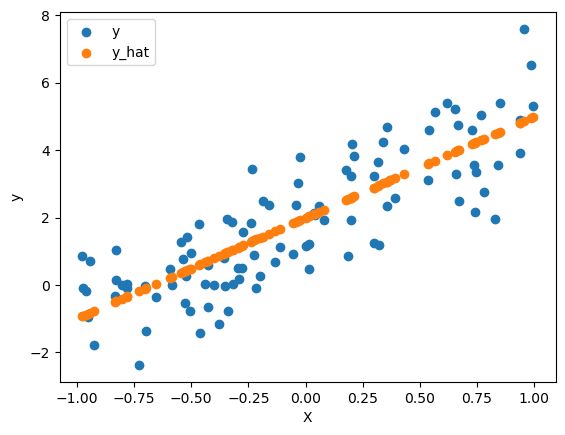

In [8]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

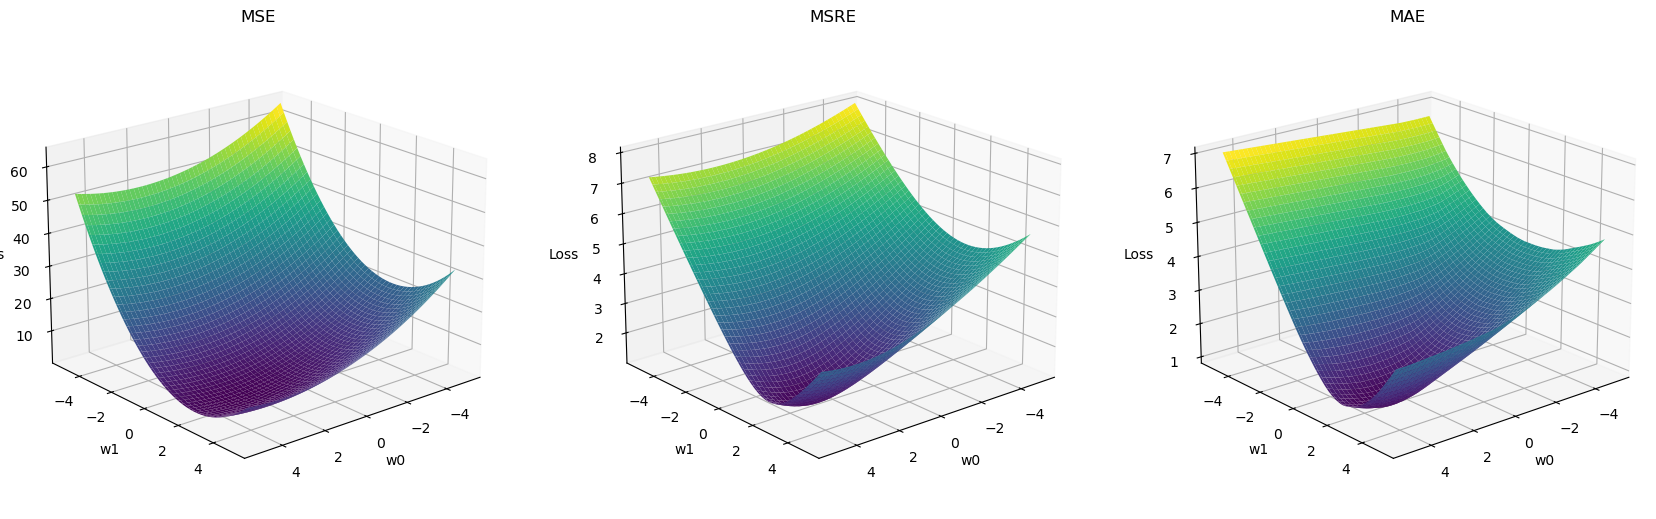

In [10]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [256]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [14]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [16]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD, NAG, RMSprop и AdaGrad с семинара:

In [33]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [20]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [35]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.learning_rate = lr
        self.gamma = gamma
        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def get_moment(self):
        return self.prev_moment

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue
                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * (prev_momentum) + self.learning_rate * param.grad
                param -= (self.gamma + 1) * self.prev_momentum[i] - self.gamma * prev_momentum



In [51]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma
        self.smoothed_squared_gradients = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue
                self.smoothed_squared_gradients[i] = self.gamma * self.smoothed_squared_gradients[i] + (1 - self.gamma) * (param.grad**2)
                param -= (self.eta *param.grad) / torch.sqrt(self.smoothed_squared_gradients[i] + self.epsilon)
                

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
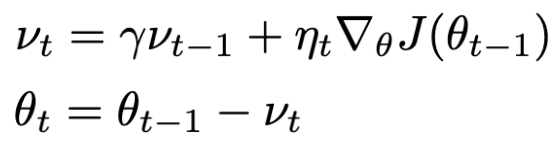

In [53]:
class Momentum(Optimizer):
    def __init__(self, params, lr = 1e-2, beta = 0.9):
        super().__init__(params)
        self.learning_rate = lr
        self.beta = beta
        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue
                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.beta * prev_momentum + self.learning_rate * param.grad
                param -= self.prev_momentum[i]
        

#### AdaDelta
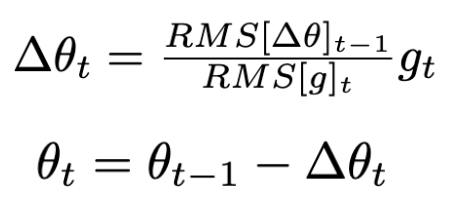

In [56]:
class Adadelta(Optimizer):
    def __init__(self, params, epsilon=1e-6, gamma=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.gamma = gamma
        self.grad_squares = [torch.zeros_like(p) for p in self.params]  
        self.delta = [torch.zeros_like(p) for p in self.params]  

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue

                self.grad_squares[i] = self.gamma * self.grad_squares[i] + (1 - self.gamma) * torch.square(param.grad)
                update = (torch.sqrt(self.delta[i] + self.epsilon) / torch.sqrt(self.grad_squares[i] + self.epsilon)) * param.grad
                param -= update
                self.delta[i] = self.gamma * self.delta[i] + (1 - self.gamma) * torch.square(update)



#### Adam
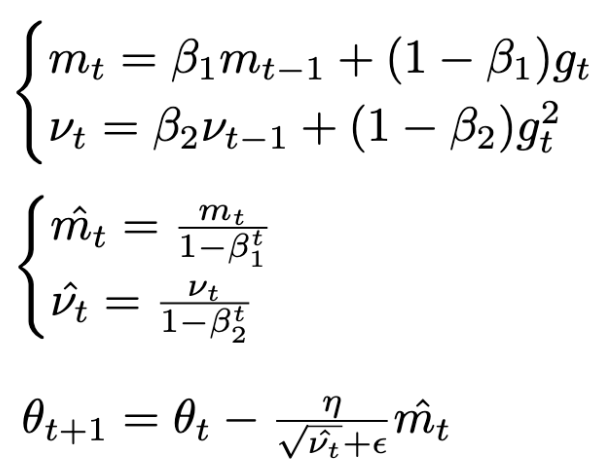

In [59]:
class Adam(Optimizer):
    def __init__(self, params, lr = 1e-1, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-6):
        
        super().__init__(params)
        self.learning_rate = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentum = [torch.zeros_like(p) for p in self.params]
        self.decay = [torch.zeros_like(p) for p in self.params]
        self.iteration = 0

    def step(self):
        with torch.no_grad():
            time = 0
            for i, param in enumerate(self.params):
                if param.grad is None:
                    continue

                self.iteration += 1
                
                momentum_prev = self.momentum[i]
                decay_prev = self.decay[i]
                
                self.momentum[i] = self.beta1 * momentum_prev + (1 - self.beta1) * param.grad
                self.decay[i] = self.beta2 * decay_prev + (1 - self.beta2) * torch.square(param.grad)

                momentum_shifted = self.momentum[i] / (1 - self.beta1**self.iteration)
                decay_shifted = self.decay[i] / (1 - self.beta2 ** self.iteration)

                # print(self.iteration)

                param -= (self.learning_rate * momentum_shifted) / (torch.sqrt(decay_shifted) + self.epsilon)
                
                

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [274]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
        ['Adadelta', Adadelta, {'epsilon': 1e-1}],
        ['Adam', Adam, {'epsilon': 1e-1, 'lr':0.5}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

#### Итак, здесь представлена анимация сравнения методов оптимизации

1.1. Сравнивая SGD и Momentum SGD, можно заметить, что вектор направления изменения функции потерь при её мининимизации начинает расходиться у оптимизаторов примерно, начиная с третьей эпохи. Это происходит, вероятно, за счет того, что изменение по параметру $\omega_{1}$ в начале меняется сильнее и вектор момента берет информацию из этого направления. Потом происходит переход и вектор момента уже больше определяется изменениями по весу $\omega_{0}$. Также по анимации видно, что при momentum'е Loss быстрее сваливается в "яму", чем при классическом SGD, при этом менее точно.


1.2. Nesterov Accelerated Gradient при подсчёте вектора momentum сглаживает его, при этом дополнительно заглядывает вперед, считая градиент в смещенной точке по каждому из параметров. Всё это ускоряет сходимость и точность сходимсоти, в сравнении с Momentum SGD.

1.3. Реализованный AdaDelta можно сравнить с AdaGrad (AdaDelta как раз-таки и призван улучшить данный алгоритм). AdaGrad учитывает накопленные квадраты градиентов, тем самым делает общий learning_rate высоким для весов с низкой историей градиентов и, наоборот, понижая learning_rate для активно менявшихся направлений. При этом AdaGrad быстро сходится к низким значениям learning_rate, что фиксит AdaDelta, накапливая (и при этом сглаживая) как квадраты градиентов, так и изменения (дельты) параметров модели. Как видно из моделирования, AdaDelta сходится быстрее (learning_rate не уходит в низкие значения). Дополнительно рассматривается и алгоритм RMSprop, который сглаживает только квадраты градиентов, что вызывает колебания у точки сходимости (квадраты градиентов становятся низкими => адаптированный learning_rate растет).

1.4. Adam, как сказали на лекции, некоторого рода "State of the Art" подход. Этот метод сглаживает, как квадраты градиентов, так и векторы моментов и учитывает влияние обоих в адаптированном learning_rate'е. Смещение вводится из статистических соображений, как я понял. Но и исходя из логики, начальные знаечения могут быть около нулевыми и не отражать ожидаемое значение параметров, поэтому они смещаются делением на небольшое число для роста.

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

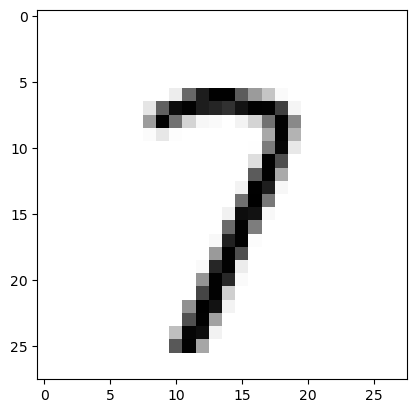

In [5]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img*0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

matplotlib_imshow(images[0])


Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [148]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS backend not available. Using CPU.")

MPS backend available. Using GPU.


In [164]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

Запустите обучение, постройте график лоссов от эпохи:

In [217]:
losses_optimizers = {}
optimizers = [
        ['SGD', SGD, {'lr': 1e-2}],
        ['AdaGrad', AdaGrad, {'eta' : 1e-2}],
        ['Adadelta', Adadelta, {'epsilon': 1e-8}],
        ['Adam', Adam, {'epsilon': 1e-8, 'lr': 1e-3}]
    ]

for optimizer in optimizers:
    network = Net()
    optimizer_used = optimizer[1](network.parameters(), **optimizer[2])

    print(f"Training {optimizer[0]}:")
    print('------------------------------------------------------')
    losses = []
    network.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        optimizer_used.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer_used.step()
    
    
        if batch_idx % 100 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                1, batch_idx * len(data), len(train_loader.dataset),
             100. * batch_idx / len(train_loader), loss.item()))
            
            losses.append(loss.item())
    print('------------------------------------------------------')
            
    losses_optimizers[optimizer[0]] = losses


Training SGD:
------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318037
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.289308
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.285988
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.270517
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.254952
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.173885
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.701824
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.021908
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.262037
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.497114
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.560720
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.642191
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.460193
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.330066
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.261668
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.431141
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.200866
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.161900
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.123600
------------------------------------------------------
Trai

  0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307623
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.428091
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.123043
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.196832
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.084395
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.014729
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.108731
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.114593
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.010037
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.270704
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.009252
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.025888
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.100385
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.008953
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.147305
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.048854
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.213661
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.029080
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.028837
------------------------------------------------------
Trai

  0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307678
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.783658
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.385885
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.389997
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.196296
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.531188
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.060666
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.054318
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.029365
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.127350
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.116344
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.059336
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.025172
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.115034
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.213586
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.005620
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.088043
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.173995
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.141921
------------------------------------------------------
Trai

  0%|          | 0/1875 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293389
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.180720
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.436211
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.104870
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.099619
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.057886
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.207203
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.007692
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.004607
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.096436
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.021428
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.002878
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.059314
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.027027
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.242356
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.049701
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.006450
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.022206
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.066701
------------------------------------------------------


In [11]:
def exponential_smoothing(data, alpha = 0.1):
    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]  # Начальное значение

    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]

    return smoothed

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

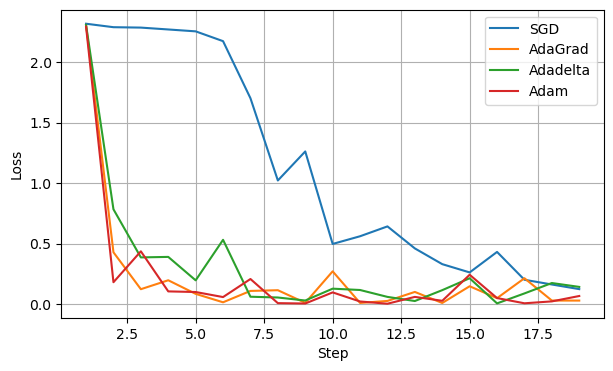

In [280]:
steps = np.arange(1, len(losses_optimizers['SGD']) + 1)
optimizer_names = ['SGD', 'AdaGrad', 'Adadelta', 'Adam']

figure = plt.figure(figsize = (7, 4))

for name in optimizer_names:
    losses = losses_optimizers[name]
    # smoothed = exponential_smoothing(losses)
    plt.plot(steps, losses, label = name)
    # plt.plot(steps, smoothed, label = name)

plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


Из графиков обучения видим, что SGD уступает в темпах сходимости другим методам оптимизации на данном датасете.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: